In [33]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow import keras, config
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

In [38]:
def TrainData():
    fake_img = r"archive\train\FAKE"
    real_img = r"archive\train\REAL"
    image = []
    label = []
    aug_img = []
    aug_label = []

    random_fake = np.random.choice(os.listdir(fake_img), 40000, replace=False)
    random_real = np.random.choice(os.listdir(real_img), 40000, replace=False)

    # Set 0 to represent fake, and 1 to represent real
    for path in tqdm(random_fake[:20000], desc='Fake Training Data'):
        data = cv2.imread(os.path.join(fake_img, path))
        image.append(data)
        label.append(0)

    for path in tqdm(random_fake[20000:], desc='Fake Training Data (to be augmented)'):
        data = cv2.imread(os.path.join(fake_img, path))
        aug_img.append(data)
        aug_label.append(0)

    for path in tqdm(random_real[:20000], desc='Real Training Data'):
        data = cv2.imread(os.path.join(real_img, path))
        image.append(data)
        label.append(1)

    for path in tqdm(random_real[20000:], desc='Real Training Data (to be augmented)'):
        data = cv2.imread(os.path.join(real_img, path))
        aug_img.append(data)
        aug_label.append(1)

    print()
    # image augmantation
    aug_img = np.array(aug_img).reshape(-1, 32, 32, 3)
    aug_label = np.array(aug_label)
    gen_image = []
    gen_label = []
    gen = ImageDataGenerator(
        rotation_range=45,
        horizontal_flip = True,
    )
    gen.fit(aug_img)

    for i, j in gen.flow(aug_img, aug_label, batch_size=200):
        gen_image.append(i)
        gen_label.append(j)
        if len(gen_image)%50==0:
            print(f'{len(gen_image)*200}/40000 augmented data generated.')
        if len(gen_image)==200:
            print('Data augmentation done')
            break
    gen_image = np.concatenate(gen_image)
    gen_label = np.array(gen_label).flatten()

    print(f'\nOrigin training data : {len(image)}')
    print(f'Augmented training data : {len(gen_image)}')

    image = np.array(image).reshape(-1, 32, 32, 3)
    label = np.array(label)

    image = np.concatenate((image, gen_image))
    label = np.concatenate((label, gen_label))
    image = image/255.0

    state = np.random.get_state()
    np.random.shuffle(image)
    np.random.set_state(state)
    np.random.shuffle(label)
    print('\nShuffle training data done.\n')
    print(f'Total training data : {len(image)}')
    
    return image, label

In [35]:
def TestData():
    fake_path = r"archive\test\FAKE"
    real_path = r"archive\test\REAL"
    image = []
    label = []
    # Set 0 to represent fake, and 1 to represent real
    for path in tqdm(os.listdir(fake_path), desc='Fake Testing Data'):
        data = cv2.imread(os.path.join(fake_path, path))
        image.append(data)
        label.append(0)
    
    for path in tqdm(os.listdir(real_path), desc='Real Testing Data'):
        data = cv2.imread(os.path.join(real_path, path))
        image.append(data)
        label.append(1)

    image=np.array(image).reshape(-1, 32, 32, 3)
    image=image/255
    label=np.array(label)

    return image,label

In [36]:
def CNN():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [39]:
train_x, train_y = TrainData()

Fake Training Data (to be augmented):  90%|████████▉ | 17950/20000 [04:31<00:31, 66.00it/s] 


KeyboardInterrupt: 

In [ ]:
test_x, test_y = TestData()

Real Testing Data: 100%|██████████| 10000/10000 [00:13<00:00, 738.10it/s]


In [ ]:
"""
Tensorflow supports running computations on GPU 

WARNING : You need to have CUDA, cuDNN, and tensorflow with version lower than 2.11.0, 
          if not, DON'T execute this cell.
"""
physical_devices = config.list_physical_devices('GPU')
config.experimental.set_memory_growth(physical_devices[0], True)
print('Running on GPU available now')

In [ ]:
model = CNN()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [ ]:
train_ac, train_loss = [], []
test_ac, test_loss = [], []

for epoch in range(1, 11):
    history = model.fit(train_x, train_y, epochs=1, batch_size=200)
    loss, ac = model.evaluate(test_x, test_y)

    train_loss.append(history.hostory['loss'])
    train_ac.append(history.history['accuaracy'])
    test_loss.append(loss)
    test_ac.append(ac)
    # prediction = model.predict(test_x)
    # prediction = [int(np.round(prediction[p])) for p in range(len(prediction))]
    # ac2=0
    # for i, j in zip(test_y, prediction):
    #     if i==j:
    #         ac2+=1
    # print(ac, ac2/len(prediction), end=' ')
    print()

 29/400 [=>............................] - ETA: 53s - loss: 0.2056 - accuracy: 0.9147

KeyboardInterrupt: 

TypeError: 'History' object is not subscriptable

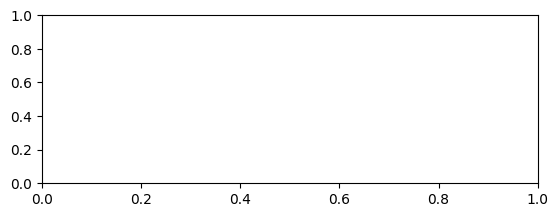

In [ ]:
# Plot the loss and accuracy of training set.

plt.subplot(1, 2, 2)
plt.plot(train_loss)
plt.plot(test_loss)
plt.axis([0, 10, 0, 1])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.subplot(1, 2, 1)
plt.plot(train_ac)
plt.plot(test_ac)
plt.axis([0, 10, 0, 100])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.show()